# Netflix movie recommendation engine
Kaggle competition link: https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data 

#### We have prepared train & test data for our model. Lets build a simple regression model on top of it. 

In [2]:
# imports
from datetime import datetime # To compute time taken wherever necessary
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
model_data_folder = 'C:/Users/ParikshitShinge/Downloads/09 - Machine Learning Case Studies/01 - Netflix Movies Recommendation/Model Ready Data'

featurized_train = pd.read_csv(model_data_folder+'/featurized_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
featurized_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


In [4]:
featurized_test = pd.read_csv(model_data_folder+'/featurized_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'], header=None)
featurized_test.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
4,28572,111,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,1


### 1. XGBoost using 13 features

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [18]:
# Preapre train data
X_train = featurized_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = featurized_train['rating']

# Prepare test data
X_test = featurized_test.drop(['user', 'movie', 'rating'], axis=1)
y_test = featurized_test['rating']

# Train model based on train data
start = datetime.now()
print('Training XGBoostRegressor...')
xgb_regressor = xgb.XGBRegressor(n_jobs=15, random_state=15, n_estimators=100)
xgb_regressor.fit(X_train, y_train, eval_metric = 'rmse')
print('Done!')
print('Time taken: {}'.format(datetime.now()-start))

Training XGBoostRegressor...
Done!
Time taken: 0:00:02.723747


Train accuracy
RMSE: 0.6294651572683201
MAPE: 0.23188514838567026

Test accuracy
RMSE: 1.213692395543615
MAPE: 0.33379025364595144

Feature importance


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

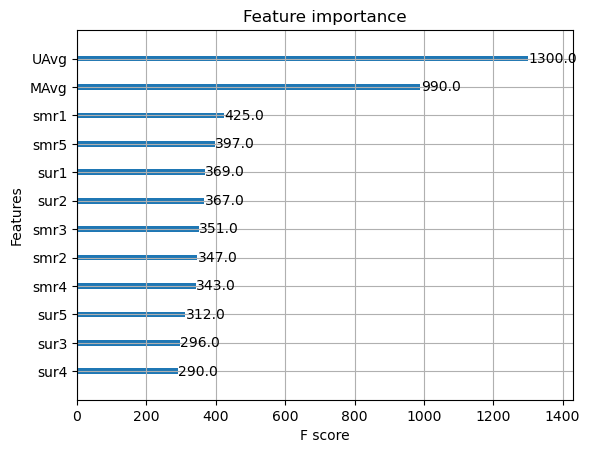

In [19]:
# Get train accuracy
y_train_pred = xgb_regressor.predict(X_train)
print('Train accuracy')
print('RMSE: {}'.format(mean_squared_error(y_train, y_train_pred)))
print('MAPE: {}'.format(mean_absolute_percentage_error(y_train, y_train_pred)))

# Get test accuracy
y_test_pred = xgb_regressor.predict(X_test)
print('\nTest accuracy')
print('RMSE: {}'.format(mean_squared_error(y_test, y_test_pred)))
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_test_pred)))

print('\nFeature importance')
xgb.plot_importance(xgb_regressor)

### 2. SurPRISE library
We'll use SurPRISE library which is built just for recommendation problems. This requires data to be in its own format so first we will transform data and then build a model.<br>
The library provides various algorithms as below:<br>
<b>Basic algorithms</b>
1. NormalPredictor<br>
NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

2. BaselineOnly<br>
BaselineOnly algorithm predicts the baseline estimate for given user and item.

<b>k-NN algorithms</b>
1. KNNBasic<br>
KNNBasic is a basic collaborative filtering algorithm.

2. KNNWithMeans<br>
KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

3. KNNWithZScore<br>
KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

4. KNNBaseline<br>
KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.

<b>Matrix Factorization-based algorithms</b>
1. SVD<br>
SVD algorithm is equivalent to Probabilistic Matrix Factorization

2. SVDpp<br>
The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

3. NMF<br>
NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

<b>Slope One</b><br>
SlopeOne is a straightforward implementation of the SlopeOne algorithm.

<b>Co-clustering</b><br>
Coclustering is a collaborative filtering algorithm based on co-clustering.

In [20]:
from surprise import Reader, Dataset

#### Transform train data

In [33]:
start = datetime.now()

reader = Reader(rating_scale=(1,5))

train_data = Dataset.load_from_df(featurized_train[['user', 'movie', 'rating']], reader)

trainset = train_data.build_full_trainset()

print('Time taken: {}'.format(datetime.now() - start))

Time taken: 0:00:00.160095


#### Transform test data

In [26]:
start = datetime.now()
testset = list(zip(featurized_test.user.values, featurized_test.movie.values, featurized_test.rating.values))
print('Time taken: {}'.format(datetime.now() - start))

Time taken: 0:00:00.002002


In [29]:
testset[1]

(941866, 71, 4)

#### Apply surprise algorithms to our dataset

In [47]:
import surprise

In [60]:
results = []
# Iterate over all algorithms
for algorithm in [surprise.NormalPredictor(), surprise.BaselineOnly(), surprise.SVD(), surprise.SVDpp(), surprise.NMF(), surprise.KNNBaseline(), surprise.KNNWithMeans(), surprise.CoClustering(), surprise.SlopeOne()]:
    # Perform cross validation
    start = datetime.now()
    algo = algorithm
    algo_str = str(algo).split(' ')[0].split('.')[-1]
    print('{} started...'.format(algo_str))
    reg = algo.fit(trainset)
    train_preds = algo.test(trainset.build_testset())
    test_preds = algo.test(testset)
    
    # Get results & append algorithm name
    train_rmse = mean_squared_error(np.array([pred.r_ui for pred in train_preds]), np.array([pred.est for pred in train_preds]) )
    test_rmse = mean_squared_error(np.array([pred.r_ui for pred in test_preds]), np.array([pred.est for pred in test_preds]) )
    train_mape = mean_absolute_percentage_error(np.array([pred.r_ui for pred in train_preds]), np.array([pred.est for pred in train_preds]) )
    test_mape = mean_absolute_percentage_error(np.array([pred.r_ui for pred in test_preds]), np.array([pred.est for pred in test_preds]) )
    
    print('{} completed... Time taken: {}'.format(algo_str,datetime.now() - start))
    
    tmp = list()
    tmp.append(algo_str)
    tmp.append(train_rmse)
    tmp.append(test_rmse)
    tmp.append(train_mape)
    tmp.append(test_mape)
    tmp.append(datetime.now() - start)
    results.append(tmp)
    
pd.DataFrame(results, columns=['Algorithm', 'Train RMSE', 'Test RMSE', 'Train MAPE', 'Test MAPE', 'Time taken']).sort_values('Test RMSE')   



NormalPredictor started...
NormalPredictor completed... Time taken: 0:00:00.731909
BaselineOnly started...
Estimating biases using als...
BaselineOnly completed... Time taken: 0:00:01.315829
SVD started...
SVD completed... Time taken: 0:00:02.172483
SVDpp started...
SVDpp completed... Time taken: 0:00:11.401236
NMF started...
NMF completed... Time taken: 0:00:03.535227
KNNBaseline started...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNBaseline completed... Time taken: 0:01:28.005930
KNNWithMeans started...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNNWithMeans completed... Time taken: 0:01:24.209863
CoClustering started...
CoClustering completed... Time taken: 0:00:04.087536
SlopeOne started...
SlopeOne completed... Time taken: 0:00:03.149543


,Algorithm,Train RMSE,Test RMSE,Train MAPE,Test MAPE,Time taken
3,SVDpp,0.494272,1.150457,0.206168,0.350189,0 days 00:00:11.401236
2,SVD,0.429431,1.150651,0.196549,0.350245,0 days 00:00:02.173480
5,KNNBaseline,0.178364,1.150763,0.110916,0.350290,0 days 00:01:28.005930
1,BaselineOnly,0.824700,1.150770,0.283321,0.350301,0 days 00:00:01.315829
4,NMF,0.463998,1.155606,0.195427,0.351532,0 days 00:00:03.535227
8,SlopeOne,0.690789,1.155704,0.247106,0.351562,0 days 00:00:03.149543
7,CoClustering,0.733949,1.155766,0.252850,0.351589,0 days 00:00:04.087536
6,KNNWithMeans,0.300473,1.155930,0.152832,0.351589,0 days 00:01:24.209863
0,NormalPredictor,2.129869,2.070521,0.428115,0.418424,0 days 00:00:00.731909


#### SVDpp gave us the best Train RMSE. Also, the BaselineOnly algorithm also fit well on the data to tive us almost same RMSE within quick time. We'll try to tune these models to see whether we get better results...